<a href="https://colab.research.google.com/github/Praneeth1189/Malaria_Detection/blob/main/malaria_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import random
from google.colab import drive

In [2]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten , Dense, BatchNormalization

In [3]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [4]:
dataset, dataset_info = tfds.load('malaria', as_supervised = True, with_info = True,
                                   split=["train"], shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteSB2GM5/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [5]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [6]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_path=PosixGPath('/tmp/tmp4wyfcbhstfds'),
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in thin blood smear images},

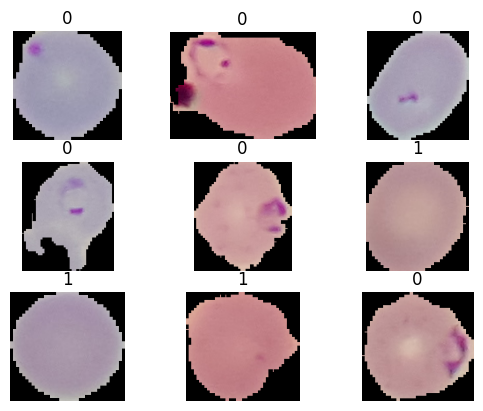

In [7]:
for i,(image,label) in enumerate(dataset[0].take(9)): # Uninfected --> 1  Paratised --> 0
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(str(label.numpy()))
  plt.axis('off')

# **Data Preprocessing**

In [8]:
def split(dataset, train_split, val_split):
  n = len(dataset)
  train_dataset = dataset.take(int(train_split*n))
  X = dataset.skip(int(train_split*n))
  val_dataset = X.take(int(val_split*n))
  test_dataset = X.skip(int(val_split*n))
  return train_dataset, val_dataset, test_dataset

In [9]:
train_dataset, val_dataset, test_dataset = split(dataset[0],0.8,0.1)

In [10]:
image_size = 224
def resize_rescale(image, label):
  return tf.image.resize(image,(image_size,image_size))/255. , label

In [11]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [12]:
for (image,label) in train_dataset.take(1):
  print(image)
  print(label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32)
tf.Tensor(1, shape=(), dtype=int64)


In [13]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=8,
                                      reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [14]:
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [15]:
test_dataset = test_dataset.batch(batch_size)

# **CNN Model Building**

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

In [17]:
random.seed(0)
model = tf.keras.Sequential([
    InputLayer(input_shape = (image_size,image_size,3)),
    data_augmentation,
    Conv2D(filters = 6, kernel_size = 3, strides = 1,
           padding = 'valid', activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.001)),
    MaxPool2D(pool_size = 2, strides = 2),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    Conv2D(filters = 16, kernel_size = 3, strides = 1,
           padding = 'valid', activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(l=0.001)),
    MaxPool2D(pool_size = 2, strides = 2),
    BatchNormalization(),
    tf.keras.layers.Dropout(0.25),

    Flatten(),

    Dense(128, activation = 'relu'),
    BatchNormalization(),
    Dense(64, activation = 'relu'),
    BatchNormalization(),
    Dense(32, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')

])

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 6)      24        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

In [19]:
model.compile(Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [20]:
history = model.fit(train_dataset, validation_data = val_dataset, epochs = 5, verbose = 1)

Epoch 1/5
689/689 [==============================] - 73s 85ms/step - loss: 0.3329 - accuracy: 0.8741 - val_loss: 3.5378 - val_accuracy: 0.6069
Epoch 2/5
689/689 [==============================] - 47s 68ms/step - loss: 0.2365 - accuracy: 0.9221 - val_loss: 0.4223 - val_accuracy: 0.8610
Epoch 3/5
689/689 [==============================] - 47s 69ms/step - loss: 0.2157 - accuracy: 0.9310 - val_loss: 0.4058 - val_accuracy: 0.8327
Epoch 4/5
689/689 [==============================] - 54s 78ms/step - loss: 0.2081 - accuracy: 0.9345 - val_loss: 0.4911 - val_accuracy: 0.5390
Epoch 5/5
689/689 [==============================] - 59s 85ms/step - loss: 0.1962 - accuracy: 0.9405 - val_loss: 0.2405 - val_accuracy: 0.9292


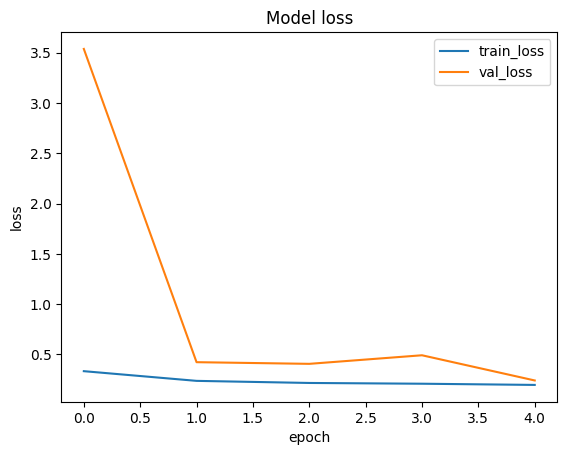

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss','val_loss'])
plt.show()

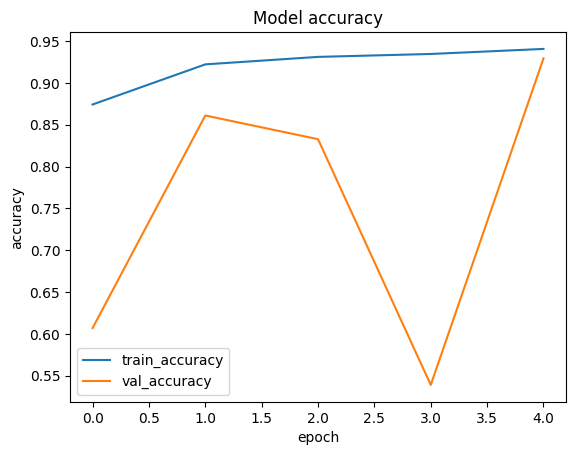

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy','val_accuracy'])
plt.show()

# **Model Evaluation**

In [23]:
model.predict(test_dataset.take(1))[0][0] # Our CNN model gives an output between 0 and 1.

1/1 [==============================] - 12s 12s/step


0.99230874

In [24]:
for (image,label) in test_dataset.take(1):
  print(label)
  print(model.predict(image)) # So if the output is greater than 0.5, it is uninfected.

tf.Tensor([1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0], shape=(32,), dtype=int64)
1/1 [==============================] - 0s 148ms/step
[[0.9908771 ]
 [0.01598233]
 [0.0028074 ]
 [0.9920392 ]
 [0.03760156]
 [0.9882764 ]
 [0.00429334]
 [0.99161536]
 [0.00450483]
 [0.98995435]
 [0.00686018]
 [0.99300694]
 [0.9917202 ]
 [0.01477496]
 [0.99038833]
 [0.4466161 ]
 [0.99218446]
 [0.0140921 ]
 [0.769389  ]
 [0.1016508 ]
 [0.26345438]
 [0.00771427]
 [0.9400737 ]
 [0.9944983 ]
 [0.01393017]
 [0.99252784]
 [0.9475114 ]
 [0.010472  ]
 [0.00209247]
 [0.991306  ]
 [0.01151345]
 [0.00607986]]


In [25]:
def output(x):
  if x >= 0.5:
    return "1(predicted)"
  else:
    return "0(predicted)"

1/1 [==============================] - 0s 28ms/step


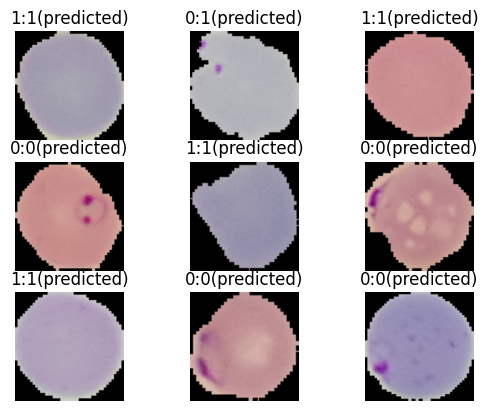

In [26]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title((str(label.numpy()[0])) + ":" + str (output(model.predict(image)[0][0])))
  plt.axis('off')

In [27]:
model.evaluate(test_dataset)

87/87 [==============================] - 14s 34ms/step - loss: 0.2650 - accuracy: 0.9188


[0.2649911940097809, 0.9187522530555725]

# **Loading and Saving**

In [28]:
model.save("malaria_model")

In [29]:
new_model = tf.keras.models.load_model("malaria_model")
new_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 6)      24        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

1/1 [==============================] - 0s 33ms/step


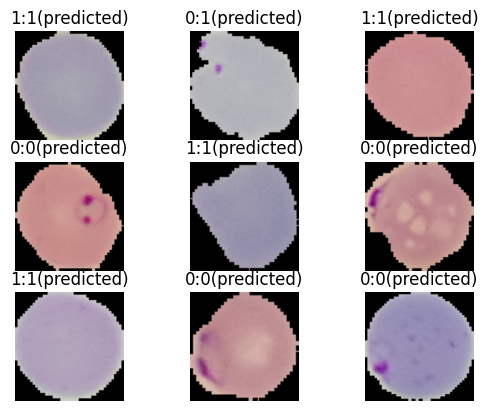

In [30]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title((str(label.numpy()[0])) + ":" + str (output(new_model.predict(image)[0][0])))
  plt.axis('off')

In [31]:
new_model.evaluate(test_dataset)

87/87 [==============================] - 15s 41ms/step - loss: 0.2661 - accuracy: 0.9180


[0.2660723328590393, 0.918026864528656]

In [32]:
model.save('hdf_model.hdf5')

In [33]:
hdf5_model = tf.keras.models.load_model('hdf_model.hdf5')
hdf5_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 6)      0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 111, 6)      24        
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)     

1/1 [==============================] - 0s 32ms/step


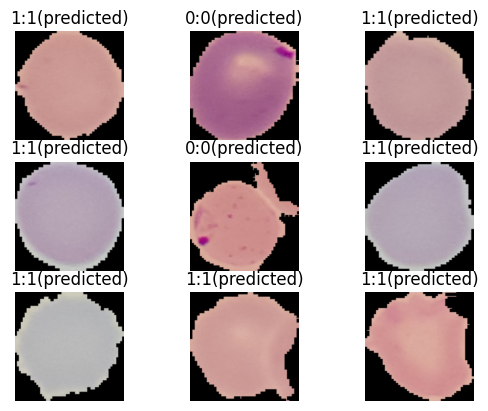

In [34]:
for i,(image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title((str(label.numpy()[0])) + ":" + str (output(hdf5_model.predict(image)[0][0])))
  plt.axis('off')

In [35]:
model.save_weights("weights/model_weights")

In [ ]:
'''model.load_weights("weights/model_weights")
model.evaluate(test_dataset)'''

# **Saving to Google Drive**

In [36]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [37]:
!cp -r /content/malaria_model/ /content/drive/MyDrive/malaria_colab